In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aymanmostafa11/eeg-motor-imagery-bciciv-2a")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/eeg-motor-imagery-bciciv-2a


In [40]:

# Improved preprocessing function
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

def preprocess_eeg_data_temporal(dataset_path, use_all_patients=True, time_steps=128):
    """
    Analyzes and preprocesses EEG motor imagery data with temporal information.
    Returns preprocessed (X, y) suitable for CNN models with temporal dimension.

    Args:
        dataset_path: Path to the dataset directory
        use_all_patients: Whether to use the combined patient file
        time_steps: Number of time steps to include for each sample

    Returns:
        Tuple of (preprocessed data, one-hot encoded labels)
    """
    import pandas as pd
    import numpy as np
    import os
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from tensorflow.keras.utils import to_categorical

    target_classes = ['left', 'right', 'foot', 'tongue']
    all_patients_df = None
    temporal_segments = []
    all_labels = []

    for filename in os.listdir(dataset_path):
        if filename.endswith(".csv"):
            filepath = os.path.join(dataset_path, filename)
            try:
                df = pd.read_csv(filepath)
                # Filter only target class events
                df = df[df['label'].isin(target_classes)]

                # Identify EEG columns
                eeg_columns = [col for col in df.columns if col.startswith("EEG")]
                print(f"Number of EEG columns: {len(eeg_columns)}")

                # If using all patients and found the combined file
                if "all_patients" in filename and use_all_patients:
                    all_patients_df = df
                    break  # We use only the combined file
                elif not use_all_patients:
                    print(f"Processing individual patient file: {filename}")
                    # Process individual files here if needed

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    if all_patients_df is not None:
        print("Using data from all patients...")
        df = all_patients_df

        # Z-score standardization of EEG columns
        eeg_columns = [col for col in df.columns if col.startswith("EEG")]
        scaler = StandardScaler()
        df[eeg_columns] = scaler.fit_transform(df[eeg_columns])

        # Extract unique trial IDs if they exist, otherwise create segments
        if 'trial' in df.columns:
            # If dataset has trial information, use it to group time points
            trial_groups = df.groupby(['trial', 'label'])
        else:
            # Otherwise, create artificial trials by segmenting the data
            print("No trial information found, creating segments from consecutive samples")
            # Add a segment ID column (every time_steps rows becomes a new segment)
            df['segment_id'] = np.arange(len(df)) // time_steps
            trial_groups = df.groupby(['segment_id', 'label'])

        # Process each trial/segment
        for (trial_id, label), group in trial_groups:
            # Skip trials/segments that are too short
            if len(group) < time_steps:
                continue

            # Get the EEG data for this trial/segment
            trial_data = group[eeg_columns].values

            # Take a segment of time_steps length
            # If trial is longer than time_steps, we can either:
            # 1. Take the first time_steps samples
            segment = trial_data[:time_steps]
            # Or 2. Take multiple overlapping segments (sliding window approach)
            # This would increase your dataset size

            # Reshape to (channels, time_steps)
            segment = segment.T  # Transpose to get channels as first dimension

            # Ensure we have the right shape
            if segment.shape == (len(eeg_columns), time_steps):
                temporal_segments.append(segment)
                all_labels.append(label)

        # Convert to numpy arrays
        X = np.array(temporal_segments)
        y = np.array(all_labels)

        # Add a channel dimension for CNN
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)  # (samples, channels, time_steps, 1)

        # One-hot encode labels
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(y)
        y_onehot = to_categorical(integer_encoded)

        print("✅ Preprocessing complete.")
        print("EEG shape with temporal info:", X.shape)
        print("Label shape:", y_onehot.shape)
        print(f"Number of samples: {X.shape[0]}")

        return X, y_onehot

    print("No combined patient data found or used.")
    return None, None


Number of EEG columns: 22
First EEG row shape: (22,)
First EEG row values: [-1.68141185  2.2454962  -0.15834995  1.16376543 -1.52365945 -0.57526702
  3.2990569   3.92818851  0.67360618  0.97220894]
Sample EEG value types: <class 'numpy.float64'>
All column names: ['patient', 'time', 'label', 'epoch', 'EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9', 'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16']

--- Statistics for BCICIV_2a_all_patients.csv ---
             patient           time          epoch         EEG-Fz  \
count  492048.000000  492048.000000  492048.000000  492048.000000   
mean        5.058824       0.300000     312.133578      -0.811991   
std         2.645100       0.232092     176.757760       7.345682   
min         1.000000      -0.100000       4.000000     -83.147212   
25%         3.000000       0.100000     159.750000      -4.968283   
50%         5.000000   

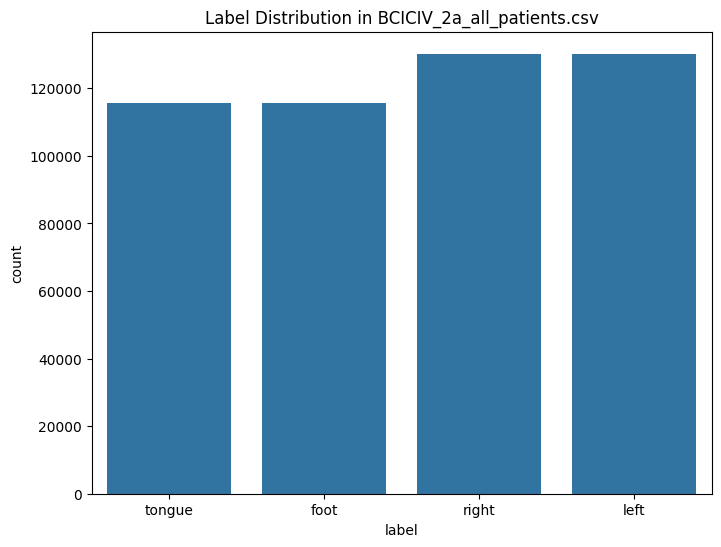

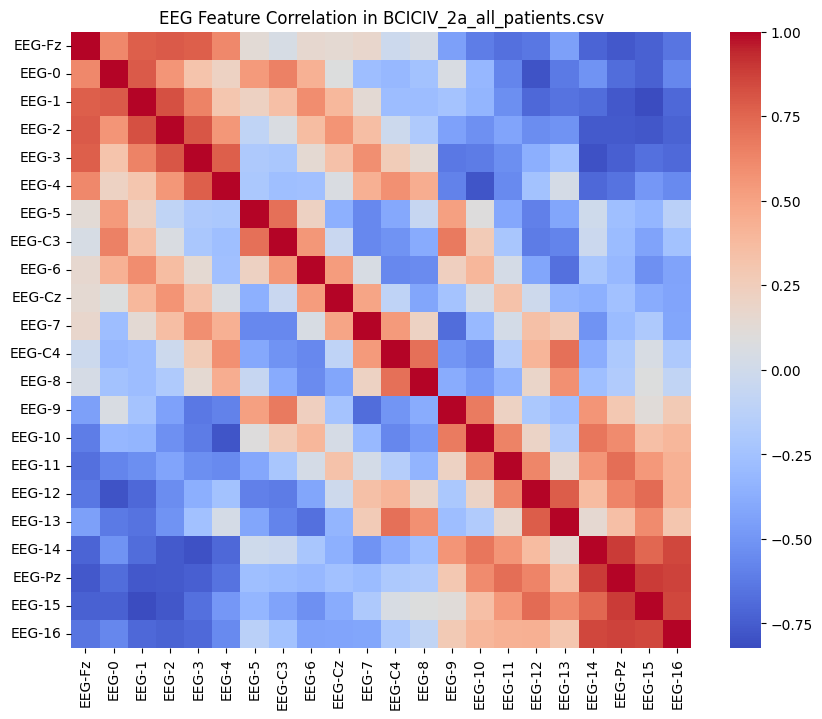

Using data from all patients...
✅ Preprocessing complete.
EEG shape: (492048, 22, 1, 1)
Labels shape: (492048, 4)


In [34]:

# Get preprocessed data:
eeg_data_reshaped, labels_onehot = preprocess_eeg_data(path, use_all_patients=True)


In [42]:
# Data splitting code
def prepare_train_val_split(eeg_data_reshaped, labels_onehot, test_size=0.1, random_state=42):
    """
    Prepares training and validation splits from preprocessed EEG data.
    Handles potential errors with data types and shapes.
    """
    from sklearn.model_selection import train_test_split

    # Ensure data is in the right format
    eeg_data_reshaped = np.array(eeg_data_reshaped)
    labels_onehot = np.array(labels_onehot)

    # Print shapes to verify
    print("EEG data shape:", eeg_data_reshaped.shape)
    print("Labels shape:", labels_onehot.shape)

    # Make sure labels_onehot is 2D
    if labels_onehot.ndim == 1:
        # Something went wrong with one-hot encoding, try to fix
        n_classes = len(np.unique(labels_onehot))
        print(f"Converting 1D labels to one-hot with {n_classes} classes")
        labels_onehot = to_categorical(labels_onehot, num_classes=n_classes)

    # Get label integers for stratification
    try:
        label_integers = np.argmax(labels_onehot, axis=1)
        print("Created stratification array with shape:", label_integers.shape)
    except Exception as e:
        print(f"Warning: Could not create stratification - {e}")
        print("Proceeding without stratification")
        label_integers = None

    # Final split with error handling
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            eeg_data_reshaped, labels_onehot,
            test_size=test_size,
            random_state=random_state,
            stratify=label_integers
        )
        print("Successfully split data:")
        print(f"Training set: {X_train.shape[0]} samples")
        print(f"Validation set: {X_val.shape[0]} samples")
        return X_train, X_val, y_train, y_val

    except Exception as e:
        print(f"Error during train/validation split: {e}")
        print("Trying alternative split without stratification...")

        try:
            X_train, X_val, y_train, y_val = train_test_split(
                eeg_data_reshaped, labels_onehot,
                test_size=test_size,
                random_state=random_state
            )
            print("Successfully split data without stratification")
            return X_train, X_val, y_train, y_val
        except Exception as e2:
            print(f"Failed to split data: {e2}")
            return None, None, None, None

In [46]:
# Modified CNN model to work with temporal information
def create_temporal_eeg_cnn(input_shape, num_classes=4):
    """
    Creates a CNN model designed for EEG data with temporal information.

    Args:
        input_shape: Tuple of (channels, time_steps, 1)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam

    model = Sequential([
        # First convolutional block - across time
        Conv2D(32, kernel_size=(1, 10), activation='relu', padding='same',
               input_shape=input_shape, name='conv_time'),
        BatchNormalization(name='bn1'),
        MaxPooling2D(pool_size=(1, 4), name='pool_time'),

        # Second convolutional block - across channels
        Conv2D(64, kernel_size=(5, 1), activation='relu', padding='same', name='conv_channels'),
        BatchNormalization(name='bn2'),
        MaxPooling2D(pool_size=(2, 1), name='pool_channels'),

        # Third convolutional block - combining features
        Conv2D(128, kernel_size=(5, 5), activation='relu', padding='same', name='conv_combined'),
        BatchNormalization(name='bn3'),
        MaxPooling2D(pool_size=(2, 2), name='pool_combined'),
        Dropout(0.3, name='dropout1'),

        # Flatten and dense layers
        Flatten(name='flatten'),
        Dense(256, activation='relu', name='dense1'),
        BatchNormalization(name='bn4'),
        Dropout(0.5, name='dropout2'),
        Dense(128, activation='relu', name='dense2'),
        Dropout(0.3, name='dropout3'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model




# Example usage of the temporal CNN
def run_temporal_eeg_training_pipeline(dataset_path, time_steps=128, epochs=50, batch_size=32):
    """
    Run the complete EEG classification pipeline with temporal information.

    Args:
        dataset_path: Path to the dataset directory
        time_steps: Number of time steps to include in each sample
        epochs: Maximum number of epochs for training
        batch_size: Batch size for training
    """
    from sklearn.model_selection import train_test_split

    print("Step 1: Preprocessing EEG data with temporal information...")
    X, y = preprocess_eeg_data_temporal(path, use_all_patients=True, time_steps=time_steps)

    if X is None or y is None:
        print("Error: Preprocessing failed.")
        return

    print("\nStep 2: Splitting data into training and validation sets...")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=np.argmax(y, axis=1)
    )

    print("\nStep 3: Creating and training temporal CNN model...")
    # Get input shape from the data
    input_shape = X_train.shape[1:]  # (channels, time_steps, 1)
    num_classes = y_train.shape[1]

    # Create and train the model
    model = create_temporal_eeg_cnn(input_shape, num_classes)
    model.summary()

    # Define callbacks (same as before)
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    import os

    save_path = "eeg_temporal_model"
    os.makedirs(save_path, exist_ok=True)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
        ModelCheckpoint(
            filepath=os.path.join(save_path, 'best_temporal_model.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate and visualize results (using the function from previous code)
    print("\nStep 4: Evaluating model performance...")
    evaluate_and_visualize(model, X_val, y_val, history, class_names=['left', 'right', 'foot', 'tongue'])

    print("\nTemporal EEG training pipeline completed successfully!")
    return model, history

# To use this:
model, history = run_temporal_eeg_training_pipeline('path/to/dataset', time_steps=128)

Step 1: Preprocessing EEG data with temporal information...
Number of EEG columns: 22
Using data from all patients...
No trial information found, creating segments from consecutive samples
✅ Preprocessing complete.
EEG shape with temporal info: (2020, 22, 128, 1)
Label shape: (2020, 4)
Number of samples: 2020

Step 2: Splitting data into training and validation sets...

Step 3: Creating and training temporal CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_time (Conv2D)              │ (None, 22, 128, 32)    │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 22, 128, 32)    │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_time (MaxPooling2D)        │ (None, 22, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_channels (Conv2D)          │ (None, 22, 32, 64)     │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 22, 32, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_channels (MaxPooling2D)    │ (None, 11, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_combined (Conv2D)          │ (None, 11, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 11, 32, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_combined (MaxPooling2D)    │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 5, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10240)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │     2,621,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,872,612 (10.96 MB)

 Trainable params: 2,871,652 (10.95 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - accuracy: 0.2684 - loss: 2.2062
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to eeg_temporal_model/best_temporal_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 566ms/step - accuracy: 0.2685 - loss: 2.2024 - val_accuracy: 0.2500 - val_loss: 1.5453 - learning_rate: 5.0000e-04
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 0.3156 - loss: 1.7043
Epoch 2: val_accuracy improved from 0.25000 to 0.26238, saving model to eeg_temporal_model/best_temporal_model.h5


51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 569ms/step - accuracy: 0.3157 - loss: 1.7039 - val_accuracy: 0.2624 - val_loss: 2.0096 - learning_rate: 5.0000e-04
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.3538 - loss: 1.5369
Epoch 3: val_accuracy did not improve from 0.26238
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 599ms/step - accuracy: 0.3541 - loss: 1.5361 - val_accuracy: 0.2599 - val_loss: 1.8905 - learning_rate: 5.0000e-04
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.4297 - loss: 1.3351
Epoch 4: val_accuracy did not improve from 0.26238
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 593ms/step - accuracy: 0.4296 - loss: 1.3354 - val_accuracy: 0.2252 - val_loss: 1.5714 - learning_rate: 5.0000e-04
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.4803 - loss: 1.2299
Epoch 5: val_accuracy did not improve from 0.26238
51/51 ━━━━━━━━━━━━━━━━━━━━ 42s 617ms/step - accuracy: 0.4800 - loss: 1.2303 - val_accuracy: 0.2500 - val_loss: 1.5114 - learning_rate: 5.0000e-04
Epoch

51/51 ━━━━━━━━━━━━━━━━━━━━ 40s 584ms/step - accuracy: 0.5597 - loss: 1.0676 - val_accuracy: 0.2995 - val_loss: 1.4951 - learning_rate: 5.0000e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6633 - loss: 0.8436
Epoch 7: val_accuracy did not improve from 0.29950
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 564ms/step - accuracy: 0.6631 - loss: 0.8442 - val_accuracy: 0.2723 - val_loss: 1.7855 - learning_rate: 5.0000e-04
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 531ms/step - accuracy: 0.7189 - loss: 0.7170
Epoch 8: val_accuracy did not improve from 0.29950
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - accuracy: 0.7189 - loss: 0.7173 - val_accuracy: 0.2822 - val_loss: 1.9238 - learning_rate: 5.0000e-04
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 532ms/step - accuracy: 0.7755 - loss: 0.5719
Epoch 9: val_accuracy did not improve from 0.29950
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 583ms/step - accuracy: 0.7755 - loss: 0.5721 - val_accuracy: 0.2871 - val_loss: 1.7764 - learning_rate: 5.0000e-04
Epoch

KeyboardInterrupt: 

In [39]:
# EEG CNN Model Training for Motor Imagery Classification :: CODE DRAFT 1

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

# Assuming you've already defined and run the preprocessing functions
# eeg_data_reshaped, labels_onehot = preprocess_eeg_data(dataset_path, use_all_patients=True)
# X_train, X_val, y_train, y_val = prepare_train_val_split(eeg_data_reshaped, labels_onehot)

def create_eeg_cnn_model(input_shape=(22, 1, 1), num_classes=4):
    """
    Creates a CNN model optimized for EEG motor imagery classification.

    Args:
        input_shape: Tuple representing input dimensions (channels, height, width)
        num_classes: Number of output classes (default: 4 for left, right, foot, tongue)

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # First convolutional block
        Conv2D(32, kernel_size=(3, 1), activation='relu', input_shape=input_shape,
               padding='same', name='conv1'),
        MaxPooling2D(pool_size=(2, 1), name='pool1'),
        Dropout(0.25, name='dropout1'),

        # Second convolutional block
        Conv2D(64, kernel_size=(3, 1), activation='relu', padding='same', name='conv2'),
        MaxPooling2D(pool_size=(2, 1), name='pool2'),
        Dropout(0.25, name='dropout2'),

        # Flatten and dense layers
        Flatten(name='flatten'),
        Dense(128, activation='relu', name='dense1'),
        Dropout(0.5, name='dropout3'),
        Dense(num_classes, activation='softmax', name='output')
    ])

    # Compile model with Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

def train_eeg_cnn(X_train, y_train, X_val, y_val, model=None,
                  epochs=50, batch_size=32, save_path="eeg_model"):
    """
    Train the CNN model with various callbacks for better performance.

    Args:
        X_train, y_train: Training data and labels
        X_val, y_val: Validation data and labels
        model: Pre-defined model (if None, creates a new one)
        epochs: Maximum number of epochs to train
        batch_size: Batch size for training
        save_path: Directory to save model checkpoints

    Returns:
        Trained model and training history
    """
    # Create model directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)

    # Create model if not provided
    if model is None:
        input_shape = X_train.shape[1:]
        num_classes = y_train.shape[1]
        model = create_eeg_cnn_model(input_shape, num_classes)

    # Print model summary
    model.summary()

    # Define callbacks
    callbacks = [
        # Stop training when validation loss stops improving
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        # Save best model
        ModelCheckpoint(
            filepath=os.path.join(save_path, 'best_model.h5'),
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        # Reduce learning rate when plateau is reached
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def evaluate_and_visualize(model, X_val, y_val, history=None, class_names=None):
    """
    Evaluate the model and visualize results.

    Args:
        model: Trained Keras model
        X_val, y_val: Validation data and labels
        history: Training history object
        class_names: List of class names (e.g., ['left', 'right', 'foot', 'tongue'])
    """
    if class_names is None:
        class_names = ['left', 'right', 'foot', 'tongue']

    # Evaluate model
    loss, accuracy = model.evaluate(X_val, y_val, verbose=1)
    print(f"\nValidation accuracy: {accuracy*100:.2f}%")
    print(f"Validation loss: {loss:.4f}")

    # Predict on validation set
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_val, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    # Plot training history if available
    if history:
        plt.figure(figsize=(12, 5))

        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training')
        plt.plot(history.history['val_accuracy'], label='Validation')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Training')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Complete training pipeline
def run_eeg_training_pipeline(dataset_path, epochs=50, batch_size=32):
    """
    Run the complete EEG classification pipeline from preprocessing to evaluation.

    Args:
        dataset_path: Path to the dataset directory
        epochs: Maximum number of epochs for training
        batch_size: Batch size for training
    """
    print("Step 1: Preprocessing EEG data...")
    # eeg_data_reshaped, labels_onehot = preprocess_eeg_data(path, use_all_patients=True)

    if eeg_data_reshaped is None or labels_onehot is None:
        print("Error: Preprocessing failed.")
        return

    print("\nStep 2: Splitting data into training and validation sets...")
    X_train, X_val, y_train, y_val = prepare_train_val_split(eeg_data_reshaped, labels_onehot)

    if X_train is None:
        print("Error: Data splitting failed.")
        return

    print("\nStep 3: Creating and training CNN model...")
    model, history = train_eeg_cnn(
        X_train, y_train,
        X_val, y_val,
        epochs=epochs,
        batch_size=batch_size
    )

    print("\nStep 4: Evaluating model performance...")
    evaluate_and_visualize(model, X_val, y_val, history)

    print("\nTraining pipeline completed successfully!")
    return model

# To run the pipeline:
model = run_eeg_training_pipeline('path/to/your/dataset', epochs=50, batch_size=32)

Step 1: Preprocessing EEG data...

Step 2: Splitting data into training and validation sets...
EEG data shape: (492048, 22, 1, 1)
Labels shape: (492048, 4)
Created stratification array with shape: (492048,)
Successfully split data:
Training set: 442843 samples
Validation set: 49205 samples

Step 3: Creating and training CNN model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 22, 1, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 11, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 11, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 11, 1, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 5, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,940 (187.27 KB)

 Trainable params: 47,940 (187.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
13832/13839 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2775 - loss: 1.3837
Epoch 1: val_accuracy improved from -inf to 0.28672, saving model to eeg_model/best_model.h5


13839/13839 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.2775 - loss: 1.3837 - val_accuracy: 0.2867 - val_loss: 1.3770 - learning_rate: 0.0010
Epoch 2/50
13832/13839 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2873 - loss: 1.3781
Epoch 2: val_accuracy improved from 0.28672 to 0.29688, saving model to eeg_model/best_model.h5


13839/13839 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.2873 - loss: 1.3781 - val_accuracy: 0.2969 - val_loss: 1.3741 - learning_rate: 0.0010
Epoch 3/50
13838/13839 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2900 - loss: 1.3766
Epoch 3: val_accuracy improved from 0.29688 to 0.29812, saving model to eeg_model/best_model.h5


13839/13839 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.2900 - loss: 1.3766 - val_accuracy: 0.2981 - val_loss: 1.3731 - learning_rate: 0.0010
Epoch 4/50
13835/13839 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2913 - loss: 1.3758
Epoch 4: val_accuracy did not improve from 0.29812
13839/13839 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.2913 - loss: 1.3758 - val_accuracy: 0.2952 - val_loss: 1.3721 - learning_rate: 0.0010
Epoch 5/50
13832/13839 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2912 - loss: 1.3754
Epoch 5: val_accuracy did not improve from 0.29812
13839/13839 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.2912 - loss: 1.3754 - val_accuracy: 0.2978 - val_loss: 1.3710 - learning_rate: 0.0010
Epoch 6/50
 2870/13839 ━━━━━━━━━━━━━━━━━━━━ 1:02 6ms/step - accuracy: 0.2930 - loss: 1.3751

KeyboardInterrupt: 